In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib.cm import get_cmap

In [2]:
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.array([[1,0],[0,-1]])
id = np.eye(2)
def create_ising_hamiltonian(N, J, g):
    hamiltonian = np.zeros((2**N,2**N))
    
    # sigma_z * sigma_z term
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i or j == i+1:
                term = np.kron(term, sigma_z)
            else:
                term = np.kron(term, id)
        hamiltonian += term
        
    # periodic boundary condition term
    for i in range(N-1):
        term = 1
        for j in range(N):
            if j == 0 or j == N:
                term = np.kron(term, sigma_z)
            else:
                term = np.kron(term, id)
        hamiltonian += term
        
    # g sigma_x term
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = np.kron(term, sigma_x)
            else:
                term = np.kron(term, id)
        hamiltonian += g*term
                
    return -J*hamiltonian

def create_magnetization_operator(N):
    magnetization_operator = np.zeros((2**N,2**N))
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = np.kron(term, sigma_z)
            else:
                term = np.kron(term, id)
        magnetization_operator += term
    return magnetization_operator/N

In [3]:
N = 9
J = 1 # set J = 1 throughout
gs = 10**np.linspace(-2,2,100)
magnetization_operator = create_magnetization_operator(N)

magnetizations = []
energies = []

for g in gs:
    hamiltonian = create_ising_hamiltonian(N, J, g)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)  
    ground_state = eigenvectors[0]  
    energies += [eigenvalues]
    magnetizations += [np.dot(np.conjugate(ground_state).T, np.dot(magnetization_operator, ground_state))]    

C:\Users\jwdes\AppData\Local\Temp\ipykernel_29384\775658560.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("gist_rainbow", len(energies))


Text(0.5, 0, 'Transverse Field Strength $g$')

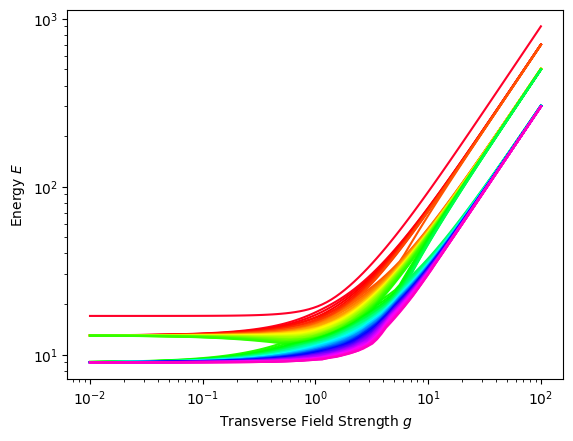

In [4]:
colors = get_cmap("gist_rainbow", len(energies))
energies = np.array(energies)
fig, ax = plt.subplots()
for idx in range(len(energies)):
    ax.plot(gs, np.abs(energies[:,idx]), color = colors(idx))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Energy $E$")
ax.set_xlabel("Transverse Field Strength $g$")

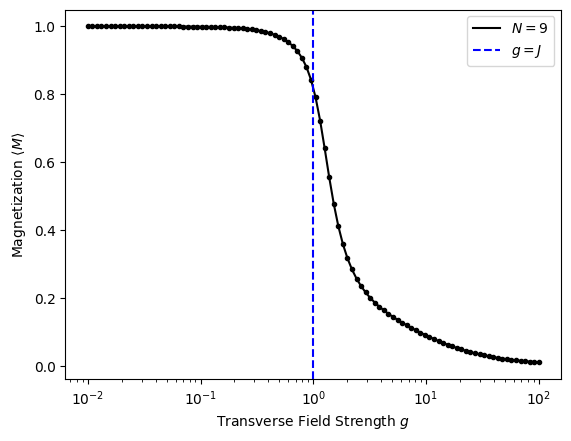

In [5]:
fig, ax = plt.subplots()
ax.plot(gs, magnetizations, '.k')
ax.plot(gs, magnetizations, '-k', label = f"$N={N}$")
ax.set_xscale('log')
ax.set_ylabel("Magnetization $ \langle M \\rangle$")
ax.set_xlabel("Transverse Field Strength $g$")
ax.axvline(x=J, linestyle = "--", color = "b", label = "$g=J$")
ax.legend(loc = "upper right")

In [15]:
N = 8
J = 1 
gs = 10**np.linspace(-2, 2, 100)
Ts = 10**np.linspace(-1, 1, 100) 
magnetization_operator = create_magnetization_operator(N)
magnetizations_image = np.zeros((len(Ts), len(gs)))

for i, g in enumerate(gs):
    for j, T in enumerate(Ts):
        hamiltonian = create_ising_hamiltonian(N, J, g)
        beta = 1 / T
        Z = np.trace(scipy.linalg.expm(-beta * hamiltonian)) 
        density_matrix = scipy.linalg.expm(-beta * hamiltonian) / Z
        magnetization_operator = create_magnetization_operator(N)
        magnetization = np.trace(magnetization_operator @ density_matrix)
        magnetizations_image[j, i] = magnetization 

C:\Users\jwdes\AppData\Local\Temp\ipykernel_29384\4104339348.py:13: RuntimeWarning: invalid value encountered in divide
  density_matrix = scipy.linalg.expm(-beta * hamiltonian) / Z


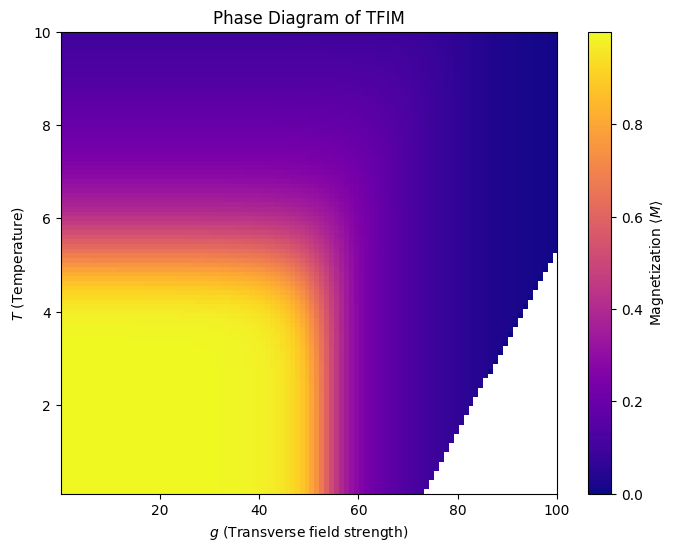

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.imshow(
    magnetizations_image,
    origin='lower', 
    extent=[gs[0], gs[-1], Ts[0], Ts[-1]], 
    aspect='auto',
    cmap='plasma'  
) 
ax.set_xlabel(r'$g$ (Transverse field strength)')
ax.set_ylabel(r'$T$ (Temperature)')
ax.set_title('Phase Diagram of TFIM')
fig.colorbar(c, ax=ax, label="Magnetization $ \langle M \\rangle$")
plt.show()